In [31]:
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime

In [32]:
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


def fontRegistered():
    font_dirs = [os.getcwd() + '/custom_fonts']
    font_files = fm.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)
    fm._load_fontmanager(try_read_cache=False)


fontRegistered()
plt.rc('font', family='NanumGothic')

In [33]:

# 1. 데이터 로드
df = pd.read_csv('data/logistics_route_data.csv')

# 2. 그래프 생성
G = nx.DiGraph()

# 출발지-도착지 간 엣지 추가 (거리 및 우선순위 기반 가중치 적용)
for idx, row in df.iterrows():
    origin = row['origin_warehouse']
    destination = row['destination_region']
    distance = row['distance_km']
    priority = row['priority_level']

    # 가중치 계산 (우선순위가 높을수록 더 낮은 가중치 부여)
    weight = distance / priority  # 긴급 배송일수록 낮은 가중치로 빠른 경로 선택

    G.add_edge(origin, destination, weight=weight, distance=distance, priority=priority)

# 3. 최적 경로 탐색 (다익스트라 알고리즘)
def find_optimal_route(graph, source, target):
    try:
        path = nx.dijkstra_path(graph, source, target, weight='weight')
        total_distance = sum(graph[u][v]['distance'] for u, v in zip(path[:-1], path[1:]))
        total_priority = sum(graph[u][v]['priority'] for u, v in zip(path[:-1], path[1:]))

        return {
            'route': path,
            'total_distance_km': total_distance,
            'total_priority': total_priority
        }
    except nx.NetworkXNoPath:
        return {
            'route': None,
            'total_distance_km': None,
            'total_priority': None
        }

# 4. 예제: 특정 출발지에서 도착지까지 최적 경로 찾기
source_warehouse = 'A'  # 서울 창고
destination_region = '강남구'  # 강남구로 배송

optimal_route = find_optimal_route(G, source_warehouse, destination_region)

# 5. 결과 출력
print(f"\n\u2728 **최적 경로 분석 결과**")
if optimal_route['route']:
    print(f"출발지: {source_warehouse}")
    print(f"도착지: {destination_region}")
    print(f"최적 경로: {' ➞ '.join(optimal_route['route'])}")
    print(f"총 거리: {optimal_route['total_distance_km']} km")
    print(f"총 우선순위 점수: {optimal_route['total_priority']}")
else:
    print(f"{source_warehouse}에서 {destination_region}까지의 경로를 찾을 수 없습니다.")

# 6. 전체 배송 요청에 대한 최적 경로 탐색 및 결과 저장
results = []
for idx, row in df.iterrows():
    source = row['origin_warehouse']
    destination = row['destination_region']
    result = find_optimal_route(G, source, destination)
    result.update({'order_id': row['order_id'], 'request_time': row['request_time']})
    results.append(result)

# 결과를 데이터프레임으로 저장
optimized_routes_df = pd.DataFrame(results)
optimized_routes_df.to_csv('data/optimized_logistics_routes.csv', index=False)

print("\n📁 최적화된 경로 데이터가 'data/optimized_logistics_routes.csv'로 저장되었습니다.")



✨ **최적 경로 분석 결과**
출발지: A
도착지: 강남구
최적 경로: A ➞ 강남구
총 거리: 212.39 km
총 우선순위 점수: 3

📁 최적화된 경로 데이터가 'data/optimized_logistics_routes.csv'로 저장되었습니다.



📊 네트워크 및 통계 시각화


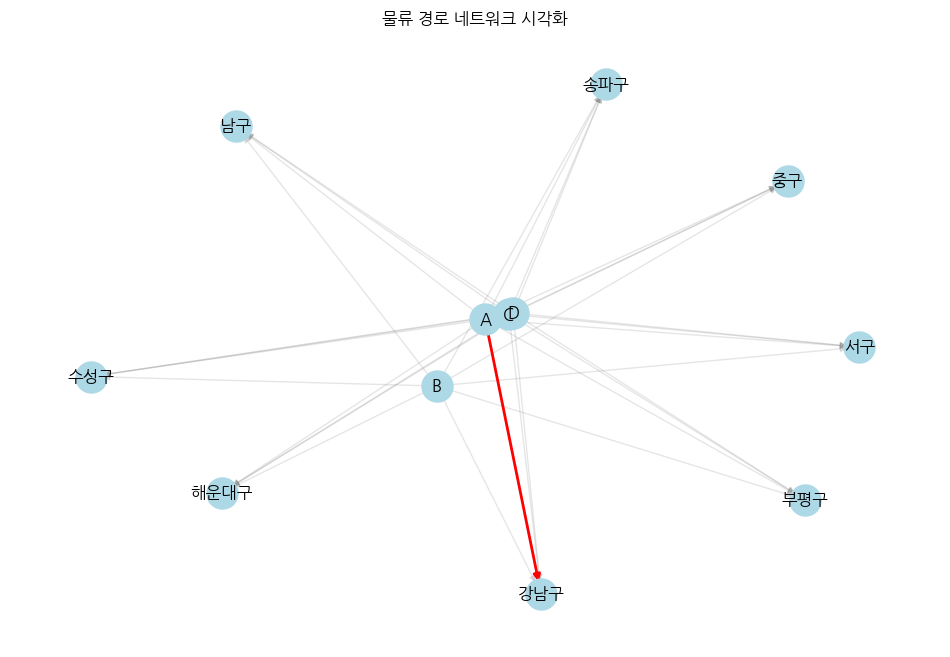

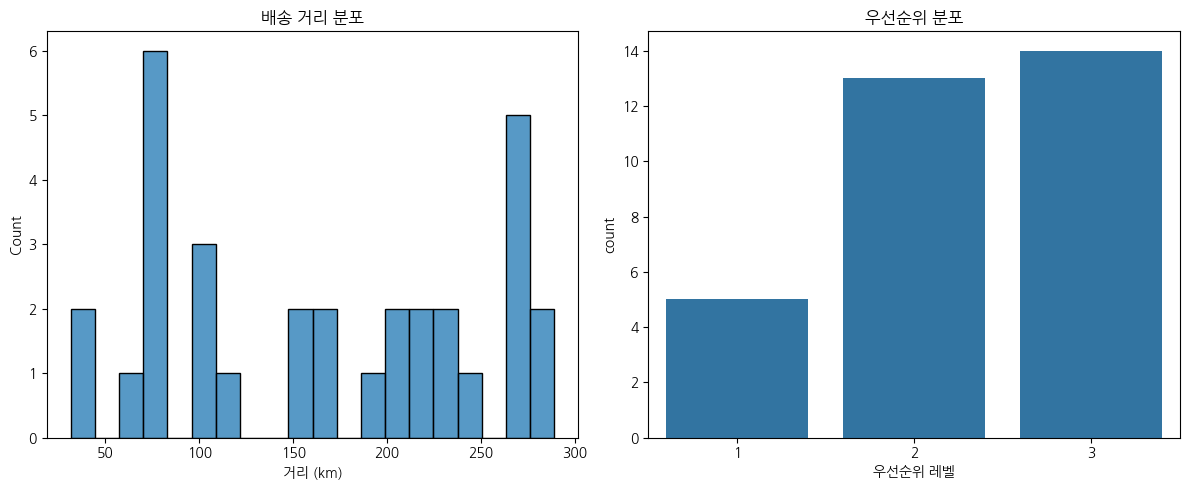

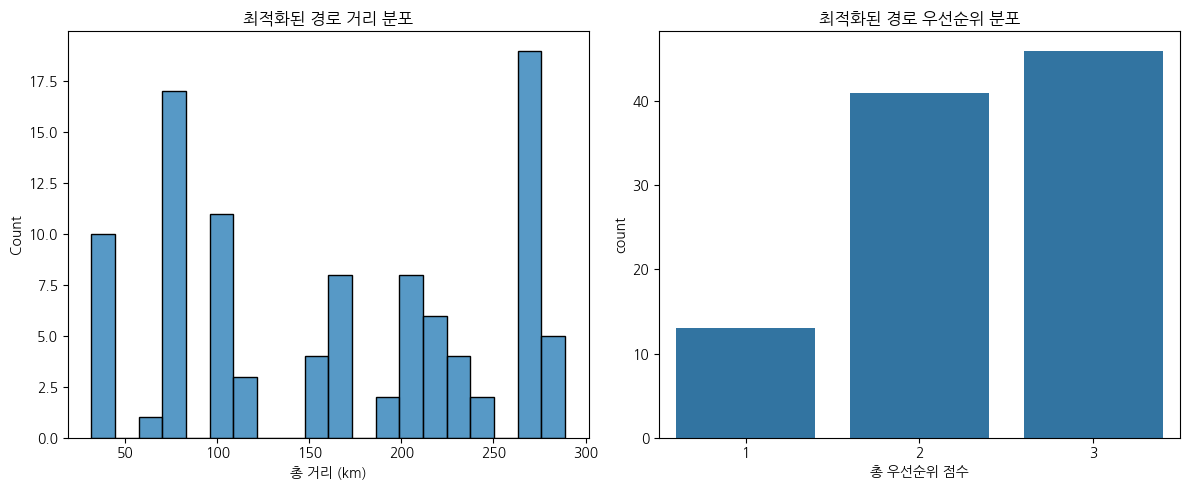


✅ 시각화가 완료되었습니다.


In [37]:
# 이 함수는 나중에 사용하려고 넣어놨다
def visualize_route(graph, route_info):
    if not route_info['route']:
        print("시각화할 경로가 없습니다.")
        return

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42)  # 레이아웃 설정

    # 모든 노드와 엣지 그리기
    nx.draw_networkx_nodes(graph, pos, node_size=700, node_color='lightgrey')
    
    # 폰트 설정
    font_family = 'Malgun Gothic' if platform.system() == 'Windows' else 'NanumGothic'
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family=font_family)
    
    nx.draw_networkx_edges(graph, pos, edge_color='lightgrey', arrows=True)

    # 최적 경로 강조 표시
    optimal_edges = list(zip(route_info['route'][:-1], route_info['route'][1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=optimal_edges, edge_color='red', width=3, arrows=True)
    
    plt.title(f"최적 경로 시각화: {' ➞ '.join(route_info['route'])}", fontsize=14)
    plt.axis('off')
    plt.show()



# 시각화 함수 정의
def visualize_route_network(G, optimal_route=None):
    plt.figure(figsize=(12, 8))
    
    # 노드 위치 설정 (spring_layout 사용)
    pos = nx.spring_layout(G)
    
    # 모든 엣지 그리기
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)
    
    # 최적 경로가 있다면 강조해서 표시
    if optimal_route:
        path_edges = list(zip(optimal_route['route'][:-1], optimal_route['route'][1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

    # 폰트 설정
    font_family = 'Malgun Gothic' if platform.system() == 'Windows' else 'NanumGothic'
    nx.draw_networkx_labels(G, pos, font_size=12, font_family=font_family)
    
    plt.title('물류 경로 네트워크 시각화')
    plt.axis('off')
    plt.show()

    # 통계 시각화
    plt.figure(figsize=(12, 5))
    
    # 거리 분포
    plt.subplot(1, 2, 1)
    distances = [d['distance'] for (u, v, d) in G.edges(data=True)]
    sns.histplot(distances, bins=20)
    plt.title('배송 거리 분포')
    plt.xlabel('거리 (km)')
    
    # 우선순위 분포
    plt.subplot(1, 2, 2)
    priorities = [d['priority'] for (u, v, d) in G.edges(data=True)]
    sns.countplot(x=priorities)
    plt.title('우선순위 분포')
    plt.xlabel('우선순위 레벨')
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
print("\n📊 네트워크 및 통계 시각화")
visualize_route_network(G, optimal_route)

# 전체 최적화 결과 분석 시각화
plt.figure(figsize=(12, 5))

# 총 거리 분포
plt.subplot(1, 2, 1)
sns.histplot(optimized_routes_df['total_distance_km'].dropna(), bins=20)
plt.title('최적화된 경로 거리 분포')
plt.xlabel('총 거리 (km)')

# 총 우선순위 점수 분포
plt.subplot(1, 2, 2)
sns.countplot(x=optimized_routes_df['total_priority'].dropna())
plt.title('최적화된 경로 우선순위 분포')
plt.xlabel('총 우선순위 점수')

plt.tight_layout()
plt.show()

print("\n✅ 시각화가 완료되었습니다.")